# Load data

In this notebook used flower dataset from google example_images.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from u_net import *

SEED = 44
BATCH_SIZE = 32
EPOCHS = 10
BUFFER_SIZE = 1000
PARALLEL_CALLS = tf.data.experimental.AUTOTUNE
HEIGHT = 256
WIDTH = 256
DEPTH = 1

DIR = tf.keras.utils.get_file(origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
                                         fname="flower_photos", untar=True)
FILES = tf.data.Dataset.list_files(DIR+"/*/*", shuffle=False)
N_ELEMENTS = tf.data.experimental.cardinality(FILES).numpy()

train_size = int(0.8 * N_ELEMENTS)
test_size = int(0.2 * N_ELEMENTS)

# Process and split

In [2]:
def get_noise(img):
    return img + 0.25 * tf.random.normal(img.shape)

def process_fn(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=DEPTH)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    noise = get_noise(img)
    return noise, img

def prepare(dataset):
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(PARALLEL_CALLS)
    return dataset

dataset = FILES.map(process_fn, num_parallel_calls=PARALLEL_CALLS)
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = prepare(train_dataset)
test_dataset = prepare(test_dataset)

# Create model

In [3]:
model = UNet([16, 32, 64], 1)

# Metrics and pass functions

In [4]:
loss_obj = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr=0.0002)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images)
        loss = loss_obj(labels, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

@tf.function
def test_step(images, labels):
    pred = model(images)

    return loss_obj(labels, pred)

# Train

In [5]:
for epoch in range(EPOCHS):
    
    train_loss = 0
    test_loss = 0
    
    for features, labels in train_dataset:
        train_loss += train_step(features, labels)

    for features, labels in test_dataset:
        test_loss += test_step(features, labels)

    print("Epoch {}, Loss: {}, Test Loss: {}"\
          .format(epoch+1, train_loss, test_loss))

Epoch 1, Loss: 1.9168879985809326, Test Loss: 0.19225865602493286
Epoch 2, Loss: 0.625117301940918, Test Loss: 0.16990052163600922
Epoch 3, Loss: 0.554081380367279, Test Loss: 0.15068158507347107
Epoch 4, Loss: 0.5244147777557373, Test Loss: 0.14874760806560516
Epoch 5, Loss: 0.5059029459953308, Test Loss: 0.14269202947616577
Epoch 6, Loss: 0.4900490641593933, Test Loss: 0.14588691294193268
Epoch 7, Loss: 0.4825083315372467, Test Loss: 0.13416828215122223
Epoch 8, Loss: 0.46572867035865784, Test Loss: 0.1319522112607956
Epoch 9, Loss: 0.45768865942955017, Test Loss: 0.1299738734960556
Epoch 10, Loss: 0.45044922828674316, Test Loss: 0.12794427573680878


# Results

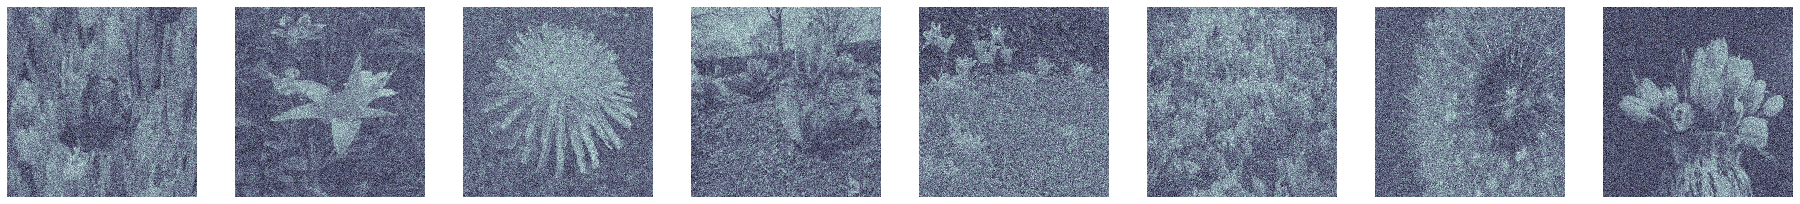

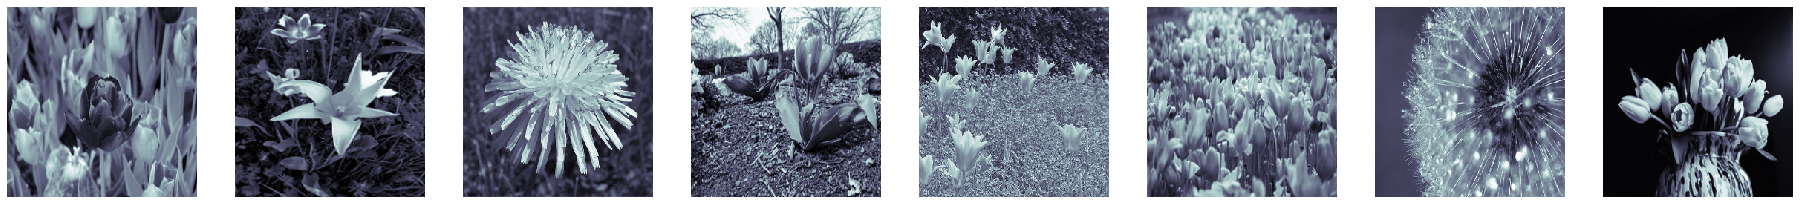

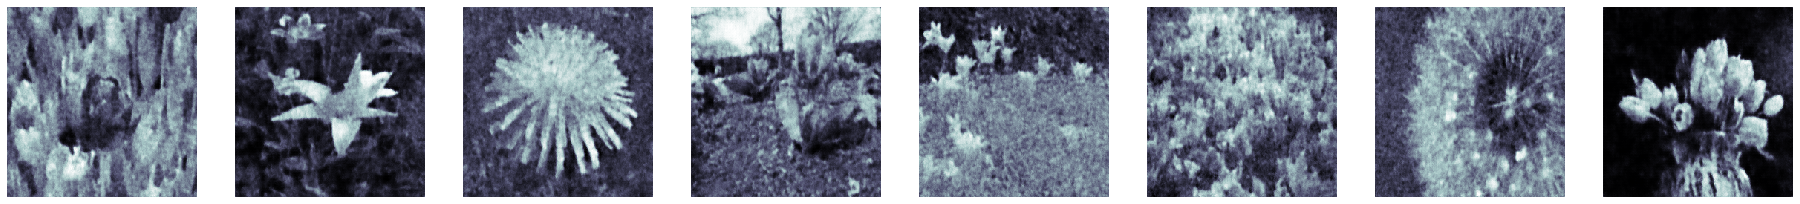

In [6]:
def show(image_batch):
    plt.figure(figsize=(32,8))
    for n in range(8):
        plt.subplot(1,8,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap="bone")
        plt.axis("off")
        
images, labels = next(iter(test_dataset))
results = model(images)

show(images)
show(labels)
show(results)